# YouTube Data Analysis


## Libraries Installations and Imports

In [176]:
from IPython.display import clear_output

!pip install contractions
!pip install -q transformers
!pip install langdetect

clear_output()

In [177]:
from googleapiclient.discovery import build
from google.colab import userdata

In [178]:
import os
import pandas as pd
import re
import contractions
from transformers import pipeline
from langdetect import detect, DetectorFactory, LangDetectException
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [179]:
do_sentiment_analysis = False # Set to True if you want to run the sentiment analysis which takes some hours
do_comments_preprocessing = False # Set to true if you want to run the clean_comments which takes some minutes due to the language detection ligrary "langdetect"

## Data Preparation and Preprocessing

### Loading the data

In [180]:
# Function to read all json files in a folder and return a DF concatenating all the information

def read_and_concatenate_json_files(folder):
    dataframes = []

    for filename in os.listdir(folder):
        if filename.endswith('.json'):
            file_path = os.path.join(folder, filename)
            df = pd.read_json(file_path)
            dataframes.append(df)
    df = pd.concat(dataframes, ignore_index=True) # Concatenate all DataFrames
    return df

In [181]:
df = read_and_concatenate_json_files('./data')

In [182]:
df.head()

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error
0,QYlsn7C24hQ,"Starring: Catherine O'Hara, Parker Posey, Chri...",88230.0,423.0,0.0,20.0,PT2M24S,0.0,[&quot;You know what they say about blind pros...,None
1,S0wq1VzKdkY,Red Dust feature trailer,15519.0,12.0,0.0,1.0,PT2M23S,0.0,[Hi ;) Thanks for posting this trailer! Would ...,None
2,k9w5RCI8PEc,Een priester en een jonge Engelse leraar raken...,266423.0,440.0,0.0,4.0,PT1M52S,0.0,"[Is it like a long-version of Kidnap Abroad?, ...",None
3,36mnx8dBbGE,Subscribe to TRAILERS: http://bit.ly/sxaw6h\nS...,4981462.0,24870.0,0.0,1350.0,PT2M30S,0.0,"[Why wear watch while swimming., The perfect B...",None
4,hQEUSZm-OjM,A comedy adventure set in the land of the Empe...,25077.0,55.0,0.0,0.0,PT1M27S,0.0,[],<HttpError 403 when requesting https://youtube...


In [183]:
df.shape

(17560, 10)

In [184]:
data = df.copy()

### Eliminating Duplicates

In [185]:
data['id'].duplicated().sum() # We have some duplicated videos

414

In [186]:
data = data.drop_duplicates(subset=['id'], keep='last')

In [187]:
data.shape

(17146, 10)

In [188]:
data['id'].duplicated().sum() # Checking duplicates were eliminated

0

### Removing Nulls

In [189]:
data.isnull().sum() # Checking the number of nulls per column

id                    0
description        2959
view_count         2959
like_count         2959
dislike_count      2959
comment_count      2959
duration           2959
favorite_count     2959
comments              0
error             12867
dtype: int64

In [190]:
# Droping columns with null values

data = data[~data['description'].isna()]
data.shape

(14187, 10)

In [191]:
data.isnull().sum() # Checking back the number of nulls per column

id                    0
description           0
view_count            0
like_count            0
dislike_count         0
comment_count         0
duration              0
favorite_count        0
comments              0
error             12867
dtype: int64

### Preparing Each Column

#### Duration

In [192]:
data.dtypes

id                 object
description        object
view_count        float64
like_count        float64
dislike_count     float64
comment_count     float64
duration           object
favorite_count    float64
comments           object
error              object
dtype: object

In [193]:
data['duration'].head() # The column durations is in the ISO 8601 duration format

222    PT1M49S
223     PT2M4S
224    PT1M50S
225    PT1M56S
226    PT1M35S
Name: duration, dtype: object

In [194]:
# The following function transform the duration from ISO 8601 to minutes format
def convert_duration_to_minutes(duration):
    pattern = re.compile(r'PT(\d+H)?(\d+M)?(\d+S)?')
    matches = pattern.match(duration)
    if not matches:
        return None

    hours = int(matches.group(1)[:-1]) if matches.group(1) else 0
    minutes = int(matches.group(2)[:-1]) if matches.group(2) else 0
    seconds = int(matches.group(3)[:-1]) if matches.group(3) else 0

    # Converts duration to minutes
    total_minutes = hours * 60 + minutes + seconds / 60
    total_minutes = round(total_minutes, 2)
    return total_minutes

In [195]:
convert_duration_to_minutes('PT1H2M3S') # checking the function

62.05

In [196]:
# Applying the convert_duration_to_minutes to the 'duration' column
data['duration'] = data['duration'].apply(convert_duration_to_minutes)

In [197]:
# checking extra nulls due to the transformation
data.isnull().sum()

id                    0
description           0
view_count            0
like_count            0
dislike_count         0
comment_count         0
duration              1
favorite_count        0
comments              0
error             12867
dtype: int64

In [198]:
# removing extra nulls
data = data[~data['duration'].isna()]
data.shape

(14186, 10)

In [199]:
# checking nulls
data.isnull().sum()

id                    0
description           0
view_count            0
like_count            0
dislike_count         0
comment_count         0
duration              0
favorite_count        0
comments              0
error             12866
dtype: int64

In [200]:
data.dtypes

id                 object
description        object
view_count        float64
like_count        float64
dislike_count     float64
comment_count     float64
duration          float64
favorite_count    float64
comments           object
error              object
dtype: object

#### Comments

In [201]:
# Function to clean a text input for sentiment analysis

def clean_text(text):
  if type(text) != str:
    return ""
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  # Remove URLs within <a> tags
  text = re.sub(r'<a[^>]*>([^<]*)<\/a>', '', text)
  # Remove special characters and digits
  text = re.sub(r'[^a-zA-Z!\s]', '', text)
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  # Convert to lowercase
  text = text.lower()
  return text

In [202]:
# Function to clean all the comments in a given row
DetectorFactory.seed = 0

def clean_comments(comments):
  cleaned_comments = []
  for comment in comments:
    try:
    # Detect the language of the text
      if detect(comment) == 'en':
        cleaned_comment = clean_text(comment)
        cleaned_comments.append(cleaned_comment)
    except LangDetectException:
      continue  # Exclude if language detection fails

  return cleaned_comments

In [203]:
if do_comments_preprocessing:
  data['comments'] = data['comments'].apply(clean_comments)
  data.to_csv('./data/youtube_cleaned.csv', index=False)
else:
  data = pd.read_csv('./data/youtube_cleaned.csv')

In [204]:
data.head()

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error
0,hXfbVIFc6t4,Subscribe to CLASSIC TRAILERS: http://bit.ly/1...,1440128.0,3600.0,0.0,323.0,2.40,0.0,['kevin costner br i remember his movies and h...,NaN
1,2_QQkB54Cg0,RISE: Blood Hunter is a supernatural thriller ...,664060.0,781.0,0.0,119.0,1.98,0.0,['will be watching this! i love lucy liu and s...,NaN
2,ansvc2Muxr0,No Copyright Infringement Intended.,196748.0,204.0,0.0,10.0,1.82,0.0,['what proof is there that hippos like chocola...,NaN
3,eYUHJ978EU8,The Librarian Quest for the Spear,72496.0,60.0,0.0,2.0,0.98,0.0,[],NaN
4,vAnsrD3kC58,Fay Grim (2006) Official Trailer #1 - Parker P...,50952.0,102.0,0.0,10.0,2.02,0.0,['what was this on dvd or something with that ...,NaN


In [205]:
data.shape

(14160, 10)

# Analytics

In [206]:
try:
  api_token = userdata.get('GOOGLE_API')
  youtube = build('youtube', 'v3', developerKey=api_token)
except Exception as e:
  print("User need to provide GOOGLE_API as Colab secret")


In [207]:
# Function to get the titles from youtube API

def get_youtube_titles(vids, client):
  """
  Download video titles from YouTube API
  ...
  Parameters
  ----------
  vids : str
      The video IDs to download titles
  """
  results = []
  # Download video data
  for vid in vids:
    try:
        video_data = youtube.videos().list( part='snippet', id=vid ).execute()
        video_data = video_data['items'][0]
        title = video_data['snippet']['title']
        results.append(title)
    except Exception as ex:
        error_message = str(ex)
        print(error_message)
        results.append("")
  return results

## 1- Top-10 videos based on total views

In [208]:
# Sorting to get the top 10 videos based on the total_views, descending

top_10_videos = data.sort_values(by='view_count', ascending=False).head(10)
top_10_videos

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error
13117,dNJdJIwCF_Y,The 2013 Academy Award Nominated film by PES. ...,477035506.0,2888709.0,0.0,72905.0,1.68,0.0,['and the other one is a little more expensive...,NaN
13548,z5rRZdiu1UE,REMASTERED IN HD!\nRead the story behind Ill C...,130241493.0,827317.0,0.0,31338.0,3.07,0.0,['my name is adam two of the beasties are adam...,NaN
12098,j-V12tL78Mc,Unfaithful movie clips: http://j.mp/1ixkUnl\nB...,126728858.0,71801.0,0.0,3969.0,2.72,0.0,['never wouldve guessed back in that he would ...,NaN
2107,SvGcGjIc16I,"Here is the trailer for Growth, the latest fil...",71795526.0,34866.0,0.0,29.0,2.10,0.0,"['is it like slither', 'eww grossbut interesti...",NaN
3499,3H8bnKdf654,Subscribe! http://YouTube.com/ClevverTV\n\nWat...,53112347.0,108371.0,0.0,22204.0,2.47,0.0,['fun fact sentinels facial features were base...,NaN
14039,bQRLVxZHKPs,"On March 13, it's the perfect day for a new Fr...",51231728.0,108086.0,0.0,0.0,0.67,0.0,[],<HttpError 403 when requesting https://youtube...
13491,sdUUx5FdySs,"My Master's Thesis Animation, which I complete...",47859734.0,609155.0,0.0,72688.0,3.17,0.0,['i have seen this bird already i just dont re...,NaN
2962,IzBVFkUM7eQ,25:37 - Jeene Ke Hain Chaar Din \n55:03 - Mujh...,42256369.0,130939.0,0.0,6566.0,151.68,0.0,['why dont you put a translation into arabic a...,NaN
4227,iCjGE43l_2E,Copyright: Les films du Losange: http://www.fi...,37883555.0,10455.0,0.0,158.0,1.70,0.0,['rohmer is only like watching paint dry if yo...,NaN
13544,9VDvgL58h_Y,The epic story of one man's encounter with the...,37797498.0,472415.0,0.0,33807.0,10.28,0.0,"['this has to become a movie i demand it!', 's...",NaN


In [209]:
top_10_ids = list(top_10_videos['id']) # Ids of top-10 based on video views

In [210]:
top_10_titles = get_youtube_titles(top_10_ids, youtube)

In [211]:
max_title_length = 20
truncated_top_10_titles = [title if len(title) <= max_title_length else title[:max_title_length] + '...' for title in top_10_titles]
top_10_videos['title'] = truncated_top_10_titles

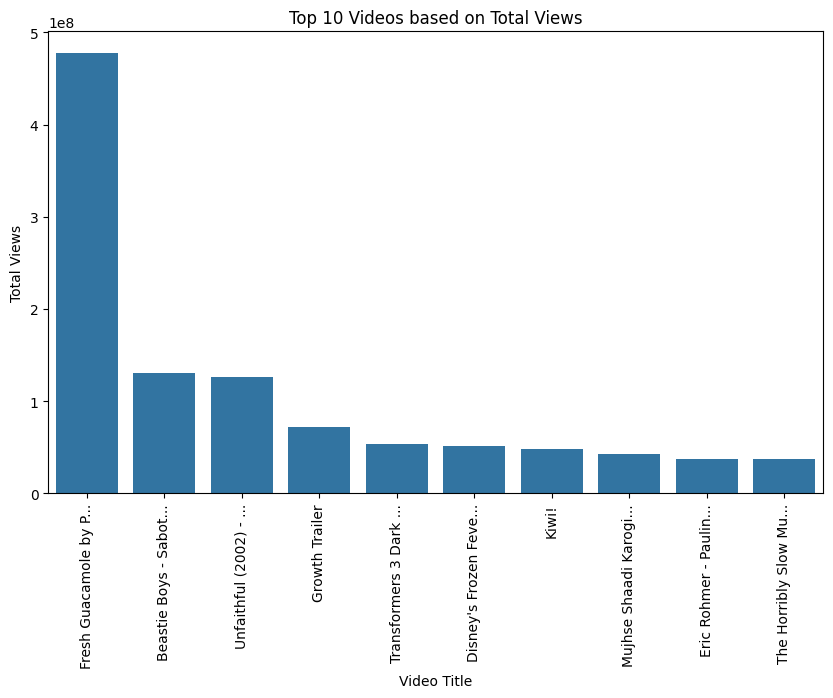

In [212]:
# Visualization top_10 videos
plt.figure(figsize=(10, 6))
sns.barplot(x='title', y='view_count', data=top_10_videos)
plt.xticks(rotation=90)
plt.title('Top 10 Videos based on Total Views')
#set x axis labels
plt.xlabel('Video Title')
plt.ylabel('Total Views')
plt.show()

In [213]:
# range of view_cont for the top 10
top_10_videos['view_count'].max(), top_10_videos['view_count'].min()

(477035506.0, 37797498.0)

Below, we can see the titles for the top-10 videos based on total views:

In [214]:
top_10_titles

['Fresh Guacamole by PES | Oscar Nominated Short',
 'Beastie Boys - Sabotage',
 'Unfaithful (2002) - The Other Woman Scene (1/3) | Movieclips',
 'Growth Trailer',
 'Transformers 3 Dark of the Moon Teaser Trailer - Official (HD)',
 "Disney's Frozen Fever Trailer",
 'Kiwi!',
 'Mujhse Shaadi Karogi - Superhit Comedy Film & Songs - Salman Khan - Priyanka Chopra - Akshay Kumar',
 'Eric Rohmer - Pauline à la plage (1983) Trailer',
 'The Horribly Slow Murderer with the Extremely Inefficient Weapon by Richard Gale']

## 2- Bottom-10 videos based on the total views

In [215]:
# Sorting based on view_count to get the Botton-10, ascending

bottom_10_videos = data.sort_values(by='view_count', ascending=True)
bottom_10_videos.head(10)

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error
13473,NyHraeDgZEc,Presented by the Coen Brothers and T Bone Burn...,0.0,160.0,0.0,8.0,101.20,0.0,['i love this documentary so much its so well ...,NaN
13235,XN_hhaVaObc,"""What's Wrong with People?"" asks Sebastian Man...",0.0,604.0,0.0,52.0,75.70,0.0,['every time i watch this there are people vis...,NaN
3121,Rk1Pcxru5OQ,Peter Bogdanovich's early career as a film wri...,0.0,59.0,0.0,20.0,122.05,0.0,['it bombed so hard it all but ended the direc...,NaN
13233,7vumUEx-IWo,From director Kunio Watanabe comes this classi...,0.0,5.0,0.0,3.0,163.78,0.0,['this movie is not the ronin you may be think...,NaN
5888,uGs2snwXVao,Movie Keyword Description. Quisque dapibus tri...,0.0,47.0,0.0,9.0,2.03,0.0,['my beloved uncle eduardo rodriguez used to t...,NaN
13484,SChG2PaXHVk,"Every year in June, nearly 2,000 athletes out ...",0.0,9.0,0.0,0.0,60.02,0.0,[],NaN
13005,3kGEv5JVcik,"To be a free man and a man with a trade, was a...",0.0,63.0,0.0,0.0,115.35,0.0,[],NaN
11750,K6Vi1VurN9s,"Academy Award-winner Clint Eastwood (""Unforgiv...",0.0,239.0,0.0,8.0,3.45,0.0,['ah the good old day of political incorrectne...,NaN
8052,AEzcWmymuEk,Poetry teacher Simone Bradley has been instruc...,0.0,104.0,0.0,4.0,1.87,0.0,['first'],NaN
3137,1hguAez-lgA,With a lovely wife and a resplendent manor tha...,0.0,30.0,0.0,5.0,99.78,0.0,['did i miss the part where they should have e...,NaN


In [216]:
list(bottom_10_videos['id'])

['NyHraeDgZEc',
 'XN_hhaVaObc',
 'Rk1Pcxru5OQ',
 '7vumUEx-IWo',
 'uGs2snwXVao',
 'SChG2PaXHVk',
 '3kGEv5JVcik',
 'K6Vi1VurN9s',
 'AEzcWmymuEk',
 '1hguAez-lgA',
 'pTwL1MFHSTI',
 'irjJknY_r0Q',
 'tZlr2PbTiow',
 'yKOeF8v67OI',
 'TmDRQWn7jgk',
 'TuuqBBVkVB8',
 'k3E6uWoNPVo',
 'rfcsCcPT818',
 '9BizzDq6kvE',
 'oB22M87q6m8',
 '07CRYIFlnCM',
 'WCDDc6lk-R4',
 'e3eHUS_ww1Q',
 '9Y_ONdPhMKM',
 '9mKkGmgPMXk',
 'lcFpknIljd4',
 'ZRFoINOGzF0',
 'GpnfFe4wLa8',
 'IzS2e9m5848',
 'p8M12Ca2XgM',
 'fOcPOv9TokA',
 'mGitACJO7y0',
 '8cNJupgsD0o',
 'knOY2dCfNI4',
 'ksHPfmx6y-4',
 'i4VLFyHQHqY',
 '5DJUIaSWdBk',
 'gW2MjSO3fws',
 'E_1qAosH3oI',
 '73Pr7saW67M',
 'wRRS8lX1jnA',
 'CNE_Q3LXDF8',
 'sv5TmHUzt_w',
 'DIE4huOayFg',
 'mFqArxUxWpc',
 '8TnEtL2aQkg',
 '5RFOEt9KNZc',
 'osErRS4m4S8',
 'gaCfY57LIkA',
 '4FcFzzJI3Z4',
 'Hqrw39KjX7k',
 'Qb1a3JiqlcE',
 'bM7KhZhoAFU',
 'CJOTcrBdw4s',
 '3ypkJwwvSIY',
 'tW9w8nY73-M',
 'zUKUavEZ3B8',
 'PCx531siQKE',
 '4yl9WtMypkg',
 '0qqvyzamlns',
 'qBSup7TzWEY',
 'wIPSUXvEoX8',
 'jY1nUp

All the bottom videos based on total views, have a view_count of 0. The botton-10 videos based on total views are:

- NyHraeDgZEc
- XN_hhaVaObc
- Rk1Pcxru5OQ
- 7vumUEx-IWo
- uGs2snwXVao
- SChG2PaXHVk
- 3kGEv5JVcik
- K6Vi1VurN9s
- AEzcWmymuEk
- 1hguAez-lgA

For completeness purposes, we created a bar diagram using just the bottom videos with no zero views count.

In [217]:
bottom_10_videos = bottom_10_videos[bottom_10_videos['view_count'] != 0].sort_values(by='view_count', ascending=True).head(10) # Getting no-zer bottom-10


In [218]:
bottom_10_ids = list(bottom_10_videos['id']) # Ids of bottom-10 based on video views
bottom_10_titles = get_youtube_titles(bottom_10_ids, youtube) # Getting the titles for those videos

In [219]:
max_title_length = 20
truncated_bottom_10_titles = [title if len(title) <= max_title_length else title[:max_title_length] + '...' for title in bottom_10_titles]
bottom_10_videos['title'] = truncated_bottom_10_titles

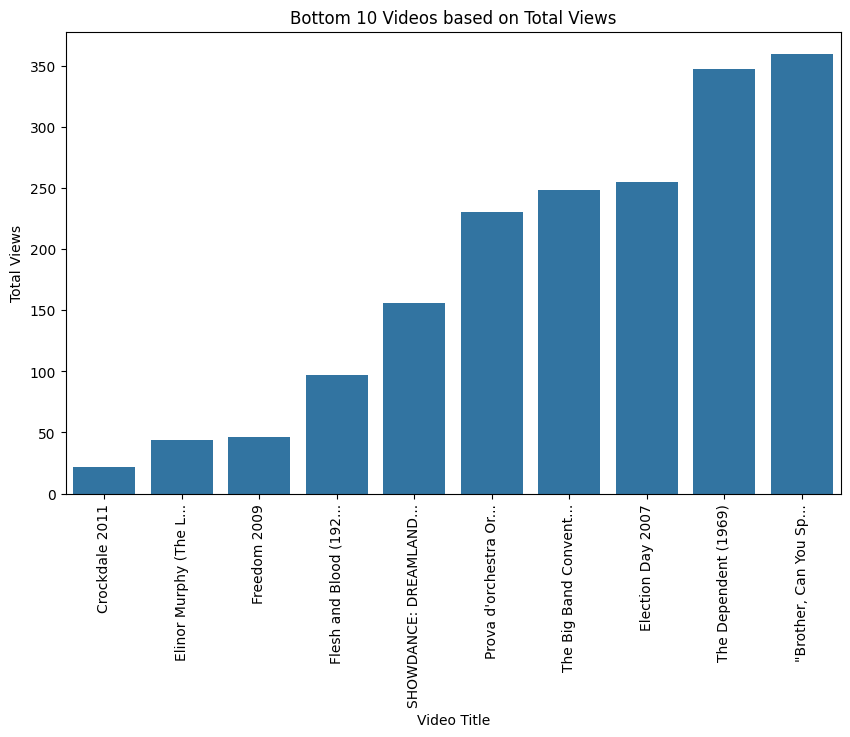

In [220]:
# Visualization top_10 videos
plt.figure(figsize=(10, 6))
sns.barplot(x='title', y='view_count', data=bottom_10_videos)
plt.xticks(rotation=90)
plt.title('Bottom 10 Videos based on Total Views')
#set x axis labels
plt.xlabel('Video Title')
plt.ylabel('Total Views')
plt.show()

Note: below we can see the bottom titles based on total views and removing those titles with zero total views

In [221]:
bottom_10_titles

['Crockdale 2011',
 'Elinor Murphy (The Long Afternoon live @ Chronic Town, 2010)',
 'Freedom 2009',
 'Flesh and Blood (1922)',
 'SHOWDANCE: DREAMLAND 2004',
 "Prova d'orchestra Orchestra Rehearsal 1978  Director Federico Fellini",
 'The Big Band Convention - Live 02.07.1998 - Love Walked In',
 'Election Day 2007',
 'The Dependent (1969)',
 '"Brother, Can You Spare a Dime?": The Great Depression']

## 3- The most liked video

In [222]:
# Sorting based on like_count, descending

most_liked_video = data.sort_values(by='like_count', ascending=False).head(1)
most_liked_video

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error
13117,dNJdJIwCF_Y,The 2013 Academy Award Nominated film by PES. ...,477035506.0,2888709.0,0.0,72905.0,1.68,0.0,['and the other one is a little more expensive...,NaN


In [223]:
# Getting the title for the most liked vide

most_liked_video_title = get_youtube_titles(list(most_liked_video['id']), youtube)
most_liked_video_title

['Fresh Guacamole by PES | Oscar Nominated Short']

The most liked video based on like_count is 'Fresh Guacamole by PES | Oscar Nominated Short' with 2888709.0 likes

## 4- The least liked video

In [224]:
# Sorting based on like_count, ascending

least_liked_video = data.sort_values(by='like_count', ascending=True).head(1)
least_liked_video

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error
9218,RQFfqUUaNqs,"Based on a best-selling autobiography, this co...",327421.0,0.0,0.0,0.0,1.98,0.0,[],<HttpError 403 when requesting https://youtube...


In [225]:
# Getting the least liked video

least_liked_video_title = get_youtube_titles(list(least_liked_video['id']), youtube)
least_liked_video_title

['Private Parts - Trailer']

The least liked video based on like_count was 'Private Parts - Trailer' with zero likes

## 5- The video with the highest durantion



In [226]:
# sorting based on duration, descending

longest_video = data.sort_values(by='duration', ascending=False).head(1)
longest_video

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error
13384,SQpu78OePTA,Poking fun at his much-publicized brouhaha wit...,0.0,47.0,0.0,0.0,199.48,0.0,[],NaN


In [227]:
# getting the title fot the video with the highest duration

longest_video_title = get_youtube_titles(list(longest_video['id']), youtube)
longest_video_title

['Kevin Smith: Too Fat for 40']

The video with the highest duration was 'Kevin Smith: Too Fat for 40' with 199.48 min

## 6- Sentiment Analysis

### Sentiment Analysis using Hugging Face Library

For sentiment analysis, we decided to use a model based on transformers architecture: [distilbert-base-multilingual-cased-sentiments-student](https://chatgpt.com/c/c76a3263-89c5-4a03-a810-7ad6b219cddc)

In [228]:
# function to get the sentiment analysis for the comments in each movie using Hugging Face transformers

def get_sentiment(comments):
  sentiment_classifier = pipeline(
        model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
    )
  result = []
  for comments_list in comments:
    scores = []
    for comment in comments_list:
      if len(scores) > 100:
        break
      try:
        sentiment = sentiment_classifier(comment, truncation=True)
        sentiment = sentiment[0]
        scores.append({sentiment['label']: sentiment['score']})
      except Exception as e:
        print(f"There was an error getting sentiment {e}")
    result.append(scores)
  return result


In [229]:
# Process the columns in batches
def process_sentiments(batch_size, path, data):
  result = []
  for start in range(0, len(data), batch_size):
    end = start + batch_size
    batch = data.iloc[start:end]
    result += get_sentiment(batch['comments'])
    with open(path, 'w') as file:
      json.dump(result, file)
  return result


To complete the sentiment analysis, the process ran during 20 hours. Therefore, we set the option in the notebook, either to run the sentiment analysis, or to import the results from sentiments.json

In [231]:
# do sentiment analysis or import file with analysis made before
if do_sentiment_analysis:
  process_sentiments(100, './data/sentiment/sentiments.json', data)

In [232]:
# Get the store values for sentiment analysis
sentiments = pd.read_json('./data/sentiment/sentiments.json').values

In [233]:
sentiments_list = [list(row) for row in sentiments]

In [234]:
data['sentiments'] = sentiments_list

In [235]:
data.head()

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error,sentiments
0,hXfbVIFc6t4,Subscribe to CLASSIC TRAILERS: http://bit.ly/1...,1440128.0,3600.0,0.0,323.0,2.40,0.0,['kevin costner br i remember his movies and h...,NaN,"[{'positive': 0.47691550850868203}, {'positive..."
1,2_QQkB54Cg0,RISE: Blood Hunter is a supernatural thriller ...,664060.0,781.0,0.0,119.0,1.98,0.0,['will be watching this! i love lucy liu and s...,NaN,"[{'positive': 0.47691550850868203}, {'positive..."
2,ansvc2Muxr0,No Copyright Infringement Intended.,196748.0,204.0,0.0,10.0,1.82,0.0,['what proof is there that hippos like chocola...,NaN,"[{'positive': 0.47691550850868203}, {'positive..."
3,eYUHJ978EU8,The Librarian Quest for the Spear,72496.0,60.0,0.0,2.0,0.98,0.0,[],NaN,"[{'positive': 0.47691550850868203}, {'positive..."
4,vAnsrD3kC58,Fay Grim (2006) Official Trailer #1 - Parker P...,50952.0,102.0,0.0,10.0,2.02,0.0,['what was this on dvd or something with that ...,NaN,"[{'positive': 0.47691550850868203}, {'positive..."


In [236]:
# function to extract the top positive comment for each video

def set_positive_comment_score(data):
  result = []
  for scores in data['sentiments']:
    sum_score = 0
    counter = 0
    for score in scores:
      if score and 'positive' in score:
        sum_score += score['positive']
        counter += 1
    result.append(sum_score / counter)
  data['positive_score'] = result

In [237]:
set_positive_comment_score(data) # Getting the positive score for each video

In [238]:
top_10_positive_score = data.sort_values(by='positive_score', ascending=False).head(10)

In [239]:
top_10_positive_score

,id,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,error,sentiments,positive_score
61,GSQ1FshsQTA,The Beastie Boys live In madison square garden...,44626.0,210.0,0.0,26.0,3.43,0.0,['fucking rock that shit!!!!!!!!!!!!!!!!!! i a...,NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.543602
13710,hM4Ctg51IeY,"Sophie Marceau and Vicent Lindon in ""L`etudian...",319079.0,505.0,0.0,16.0,1.50,0.0,['ah la la ce film!!!!!!!!!!!!!!!!!!!trop bon!...,NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.528149
13892,2JcRf_sTenM,six drummers,15554.0,124.0,0.0,6.0,9.50,0.0,['show!!!!!!!!!!!! amei! i loved!'],NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.520472
12147,UyhSv4E8E0o,An original 1985 television spot for the werew...,18757.0,79.0,0.0,8.0,0.45,0.0,['happy th anniversary stephen kings quotsilve...,NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.512784
3936,R_0Ej5N-hFQ,Dog Soldier Trailer,1209109.0,1119.0,0.0,435.0,1.03,0.0,"['this movie came out on my birthday', 'werewo...",NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.510867
1920,W6IAY9bSP7s,Trailer for Rankin-Bass classic.,2155302.0,668.0,0.0,130.0,0.02,0.0,['happy th anniversary quotrudolph the rednose...,NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.505555
12440,u78eh_DAwzA,Varm dramakomedi om ovanlig vänskap. Sverigepr...,16414.0,33.0,0.0,8.0,1.97,0.0,['jag lskar er!!!!!!!!! caroline'],NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.499246
11427,KDkbdH8zwDE,"I don't want to spoil the developments, so I'l...",9784.0,22.0,0.0,2.0,1.27,0.0,['woody is a genius!!!!!!'],NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.496879
13817,mi5t3AvzgLc,Ett par riktigt sköna klipp från Sällskapsresa...,153176.0,183.0,0.0,58.0,9.72,0.0,['ut! inn! ut! iiiin! he he'],NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.493995
5265,qYUzYGRHEo4,Available on DVD through www.umbrellaent.com.a...,17076.0,109.0,0.0,4.0,2.13,0.0,['rock and roll!!!!! byeeeeeeeeeeeeeeeeeeaaaaa...,NaN,"[{'positive': 0.47691550850868203}, {'positive...",0.490400


In [240]:
# get tiles
top_10_positive_score_titles = get_youtube_titles(list(top_10_positive_score['id']), youtube)
max_title_length = 20
truncated_top_10_titles_score = [title if len(title) <= max_title_length else title[:max_title_length] + '...' for title in top_10_positive_score_titles]
top_10_positive_score['title'] = truncated_top_10_titles_score

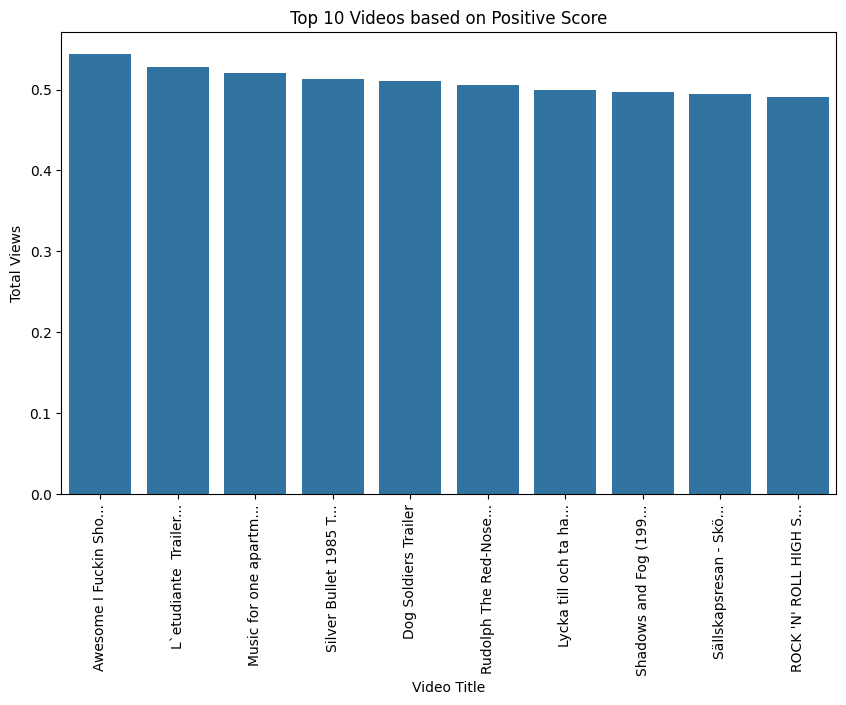

In [241]:
# bar char for top-10 highest sentiment score

plt.figure(figsize=(10, 6))
sns.barplot(x='title', y='positive_score', data=top_10_positive_score)
plt.xticks(rotation=90)
plt.title('Top 10 Videos based on Positive Score')
plt.xlabel('Video Title')
plt.ylabel('Total Views')
plt.show()


The following is the list of the top-10 videos based on the sentiment analysis score for the comments

In [242]:
top_10_positive_score_titles

['Awesome I Fuckin Shot That (Beastie Boys 2006) Paul Revere',
 'L`etudiante  Trailer Sophie Marceau',
 'Music for one apartment and six drummers by Ola SIMONSSON, Johannes STJÄRNE NILSSON 2001',
 'Silver Bullet 1985 TV trailer',
 'Dog Soldiers Trailer',
 'Rudolph The Red-Nosed Reindeer',
 'Lycka till och ta hand om varandra - OFFICIAL TRAILER',
 'Shadows and Fog (1991) Trailer',
 'Sällskapsresan - Sköna klipp (Snowroller)',
 "ROCK 'N' ROLL HIGH SCHOOL Trailer"]